In [1]:
import os
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import Transforms as T

### Global Variables AND Helper Functions:

In [15]:
random_seed = 0
FRAME_PATH = 'Frames'
os.makedirs(FRAME_PATH, exist_ok=True)

#_________/Control Switches\_________
NEW_SEEDS = True
NEW_AUGMENTS = True
NEW_SPLIT = True
SAVE_NPY = True
SAVE_DF = True

#______/Image Initialization Data\________
DIMENSION = 240
IMAGE_SHAPE = (DIMENSION, DIMENSION)
IMAGE_BASE = np.zeros(IMAGE_SHAPE)
BASE_LABELS = ['file_path', 'image_width', 'image_height',
               'center_x_ratio', 'center_y_ratio', 'num_rings']

CENTER_X, CENTER_Y = int(DIMENSION/2), int(DIMENSION/2)
CENTER_MASK = IMAGE_BASE
CENTER_MASK[CENTER_Y, CENTER_X] = 1

Y, X= np.ogrid[0:DIMENSION, 0:DIMENSION]
CIRC_EQ = (X- CENTER_X)**2 + (Y - CENTER_Y)**2
NUM_RINGS = 12
RADII_LABELS = [f'radius_{i}' for i in range(1, NUM_RINGS + 1)]

MIN_RING_WIDTH = 0.001 * DIMENSION
MAX_RING_WIDTH = 0.02 * DIMENSION
RADIUS_BOUND = 0.45 * DIMENSION

TRANSFORMATIONS = [T.Random_Patch(max_num_patch=100), T.Random_Shift(), T.Random_Patch()]



#_______/Creation Function Inputs\_________
NUM_SEED_IMAGES = 12
NUM_AUGMENTS = 2
SEED_POOL = NUM_SEED_IMAGES


#________/Helper Functions\_________
def bresenham_line(x0, y0, x1, y1):
    """Generate points on a line from (x0, y0) to (x1, y1) using Bresenham's algorithm."""
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((y0, x0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return points

def split_train_valid_test(data: pd.DataFrame(), train_ratio: float=0.45, valid_ratio: float=0.45, test_ratio: float=0.1):
    num_samples = len(data)
    num_train = int(train_ratio * num_samples)
    num_valid = int(valid_ratio * num_samples)
    train_df = data.sample(n=num_train)
    data = data.drop(train_df.index)
    valid_df = data.sample(n=num_valid)
    data = data.drop(valid_df.index)
    test_df = data

    train_df.to_pickle(os.path.join(FRAME_PATH,'train_frame.pickle'))
    valid_df.to_pickle(os.path.join(FRAME_PATH, 'valid_frame.pickle'))
    test_df.to_pickle(os.path.join(FRAME_PATH, 'test_frame.pickle'))

    return None


### Creation Functions

In [16]:
def create_seeds(num_seeds=NUM_SEED_IMAGES, seed_label='S', save_directory='Seed_Images', image_shape=IMAGE_SHAPE, 
                 num_rings=NUM_RINGS, num_ring_variance=True, wobbly_rings=True, wobbly_frequency=3,
                 inner_outer_masking=True, inner_outer_frequency=4):
    
    os.makedirs(save_directory, exist_ok=True)

    seed_data = []
    inner_flag = 0
    outer_flag = 0

    for index in range(1, num_seeds + 1):

        if index % wobbly_frequency == 0:
            wobble_flag = 1
        else:
            wobble_flag = 0

        if index % inner_outer_frequency == 0 and inner_flag != 1:
            inner_flag, outer_flag = 1, 0
        elif index % inner_outer_frequency == 0 and outer_flag != 1:
            inner_flag, outer_flag = 0, 1

        IMAGE_BASE = np.zeros((image_shape))

        if num_ring_variance:
            num_rings_v = random.randint(2, num_rings)

        radii = np.cumsum(np.random.random(num_rings_v))

        min_radius = radii[0]
        max_radius = radii[-1]

        radii_norms = radii / max_radius
        radii_pixels = radii_norms * RADIUS_BOUND

        radii_keys = RADII_LABELS
        radii_values = list(radii_norms[0:num_rings_v])
        radii_values += [0 for x in range(NUM_RINGS - len(radii_values))]

        if inner_outer_masking:
            if inner_flag:
                num_rings_v = int(num_rings_v / 2)
                radii_pixels = radii_pixels[num_rings_v:]
            if outer_flag:
                num_rings_v = int(num_rings_v / 2)
                radii_pixels = radii_pixels[0:num_rings_v]
                
        for ring in range(0, num_rings_v):
            radius_outer = radii_pixels[ring]
            radius_inner = radius_outer - random.uniform(MIN_RING_WIDTH, MAX_RING_WIDTH)

            wobble_flag2 = random.randint(1, 2)
            if wobbly_rings and wobble_flag and wobble_flag2:
                t = np.linspace(0, 2 * np.pi, 500)
                fragments = random.randint(3, 5)
                shift = random.uniform(0.008, 0.04)
                r_outer = radius_outer * (1 + shift * np.sin(fragments * t))
                r_inner = radius_inner * (1 + shift * np.sin(fragments * t))

                # Iterate through angles and draw the fragmented ring
                for angle in range(500):
                    y_outer, x_outer = r_outer[angle] * np.sin(t[angle]) + image_shape[0]//2, r_outer[angle] * np.cos(t[angle]) + image_shape[1]//2
                    y_inner, x_inner = r_inner[angle] * np.sin(t[angle]) + image_shape[0]//2, r_inner[angle] * np.cos(t[angle]) + image_shape[1]//2
                    points = bresenham_line(int(x_inner), int(y_inner), int(x_outer), int(y_outer))
                    for y, x in points:
                        if 0 <= x < image_shape[1] and 0 <= y < image_shape[0]:
                            IMAGE_BASE[y, x] = 1
            else:
                mask_outer = CIRC_EQ <= radius_outer**2
                mask_inner = CIRC_EQ > radius_inner**2
                IMAGE_BASE[mask_outer & mask_inner] = 1

        
        save_path = os.path.join(save_directory, f'{seed_label}({index}).npy')

        if SAVE_NPY:
            np.save(save_path, IMAGE_BASE)

        base_keys = BASE_LABELS
        base_values = [save_path, DIMENSION, DIMENSION, 0.5, 0.5, num_rings_v]

        combined_keys = [*base_keys, *radii_keys]
        combined_values = [*base_values, *radii_values]

        seed_data.append({key: value for key, value in 
                          zip(combined_keys, combined_values)})
        
    seed_frame = pd.DataFrame(seed_data)

    if SAVE_DF:
        seed_frame.to_pickle(os.path.join(FRAME_PATH,'seed_frame.pickle'))

    return None


def augment_seeds(num_augments=NUM_AUGMENTS, augment_label='A', save_directory='Augmented_Images',
                  seed_pool=SEED_POOL, seed_data=None, transforms=TRANSFORMATIONS):
    
    os.makedirs(save_directory, exist_ok=True)

    augment_data = []
    
    for i in range(SEED_POOL):
        seed_img = np.load(seed_data['file_path'][i])
        num_rings = seed_data['num_rings'][i]

        radii_keys = RADII_LABELS
        radii_values = seed_data.loc[i, [f'radius_{col}' for col in range(1, NUM_RINGS + 1)]]

        for j in range(NUM_AUGMENTS):
            augment_path = os.path.join(save_directory, f'S({i + 1})-{augment_label}({j + 1}).npy')
            augment_img = seed_img
            helper = copy.deepcopy(CENTER_MASK)
            
            for transform in transforms:
                augment_img, helper = transform(augment_img, helper)
            
            indices = np.where(helper==1)
            x, y, n = 0, 0, 0
            for coord in zip(*indices):
                x += coord[1]
                y += coord[0]
                n += 1

            x, y = x/n, y/n
            x_ratio, y_ratio = x/helper.shape[1], y/helper.shape[0]

            if SAVE_NPY:
                np.save(augment_path, augment_img)

            base_keys = BASE_LABELS
            base_values = [augment_path, DIMENSION, DIMENSION, x_ratio, y_ratio, num_rings]

            combined_keys = [*base_keys, *radii_keys]
            combined_values = [*base_values, *radii_values]

            augment_data.append({key: value for key, value in
                                 zip(combined_keys, combined_values)})
            
    augment_frame = pd.DataFrame(augment_data)

    if SAVE_DF:
        augment_frame.to_pickle(os.path.join(FRAME_PATH, 'augment_frame.pickle'))

    return None

In [17]:
if NEW_SEEDS:
    create_seeds()

if NEW_AUGMENTS:
    augment_seeds(seed_data=pd.read_pickle(os.path.join(FRAME_PATH, 'seed_frame.pickle')))

if NEW_SPLIT:
    augment_frame = pd.read_pickle(os.path.join(FRAME_PATH,'augment_frame.pickle'))
    split_train_valid_test(augment_frame)

In [18]:
augment_frame = pd.read_pickle(os.path.join(FRAME_PATH,'augment_frame.pickle'))
augment_frame.head()

,file_path,image_width,image_height,center_x_ratio,center_y_ratio,num_rings,radius_1,radius_2,radius_3,radius_4,radius_5,radius_6,radius_7,radius_8,radius_9,radius_10,radius_11,radius_12
0,Augmented_Images\S(1)-A(1).npy,240,240,0.554167,0.466667,11,0.029204,0.134080,0.278566,0.320124,0.465287,0.58869,0.634653,0.701318,0.713211,0.828055,1.0,0.0
1,Augmented_Images\S(1)-A(2).npy,240,240,0.583333,0.441667,11,0.029204,0.134080,0.278566,0.320124,0.465287,0.58869,0.634653,0.701318,0.713211,0.828055,1.0,0.0
2,Augmented_Images\S(2)-A(1).npy,240,240,0.491667,0.454167,10,0.101432,0.151174,0.240484,0.313698,0.438183,0.58228,0.755347,0.787584,0.885502,1.000000,0.0,0.0
3,Augmented_Images\S(2)-A(2).npy,240,240,0.445833,0.404167,10,0.101432,0.151174,0.240484,0.313698,0.438183,0.58228,0.755347,0.787584,0.885502,1.000000,0.0,0.0
4,Augmented_Images\S(3)-A(1).npy,240,240,0.470833,0.550000,2,0.487696,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


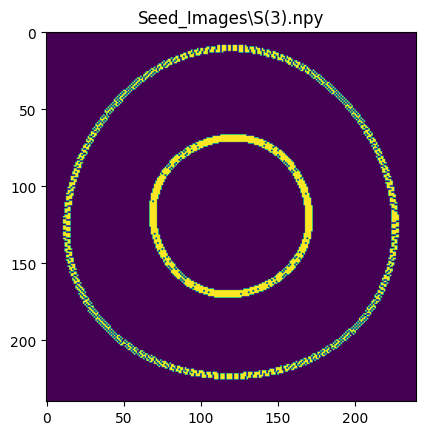

In [19]:
x = 2
seed_frame = pd.read_pickle(os.path.join(FRAME_PATH, 'seed_frame.pickle'))
img = np.load(seed_frame['file_path'][x])
plt.imshow(img)
plt.title(seed_frame['file_path'][x])
plt.show()

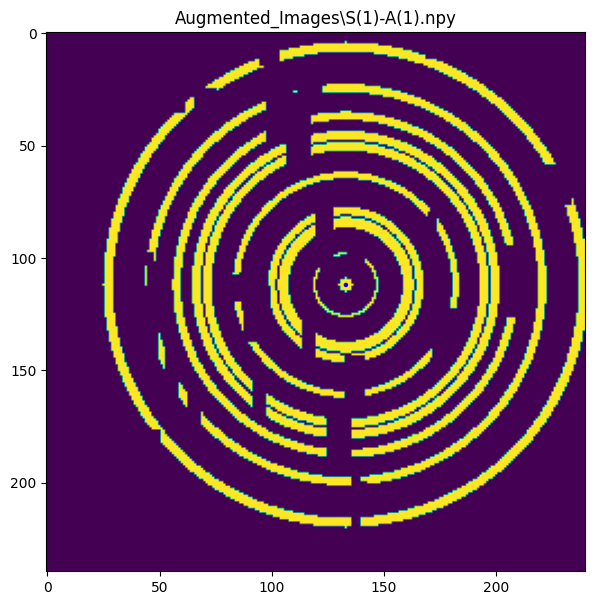

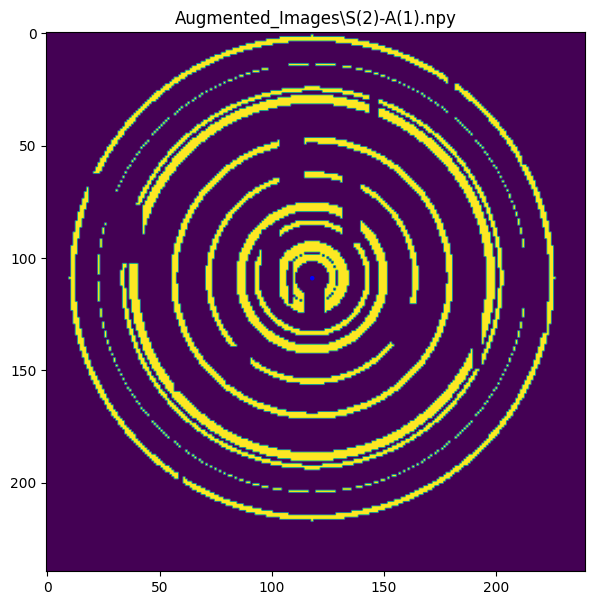

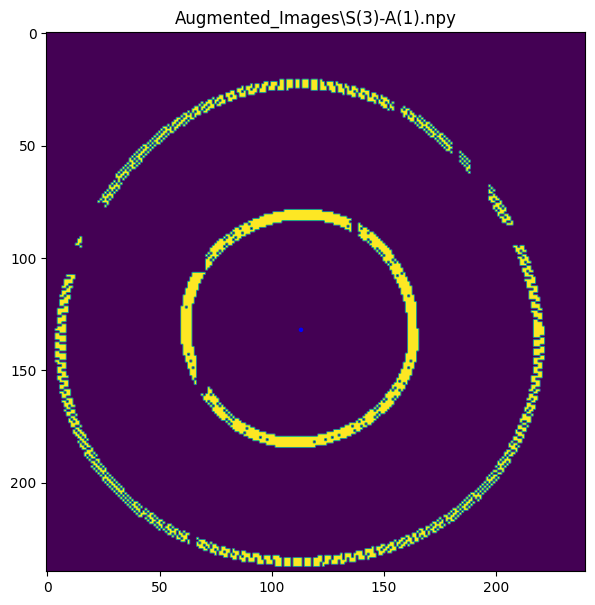

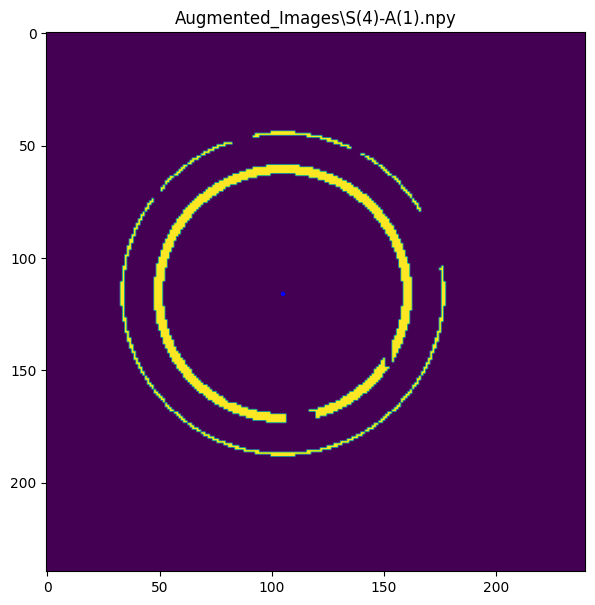

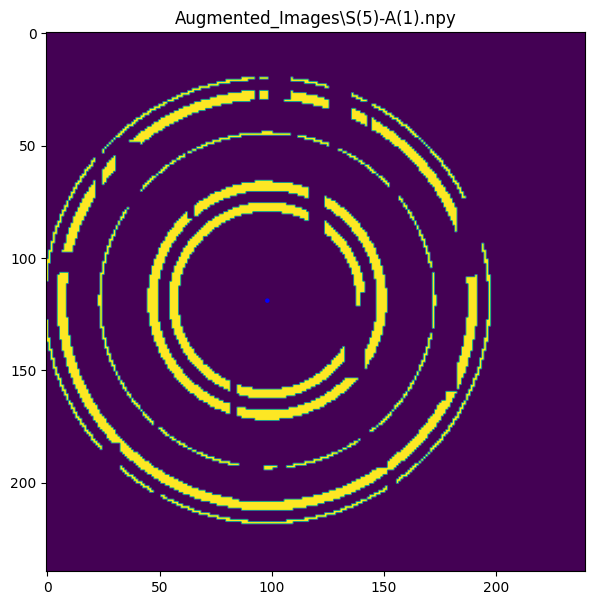

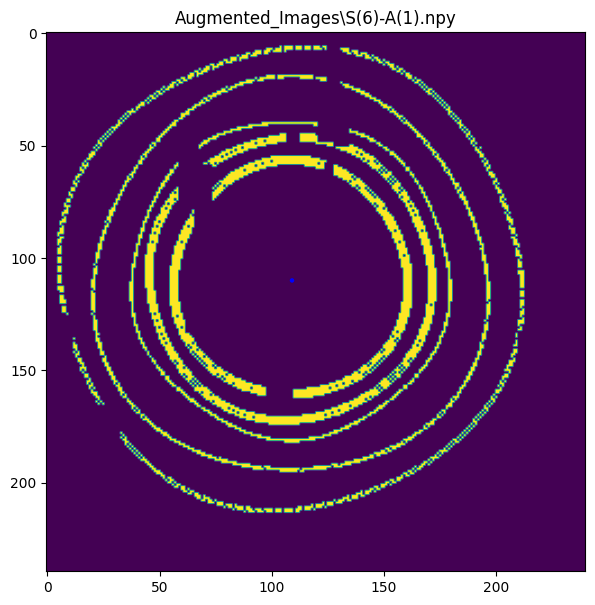

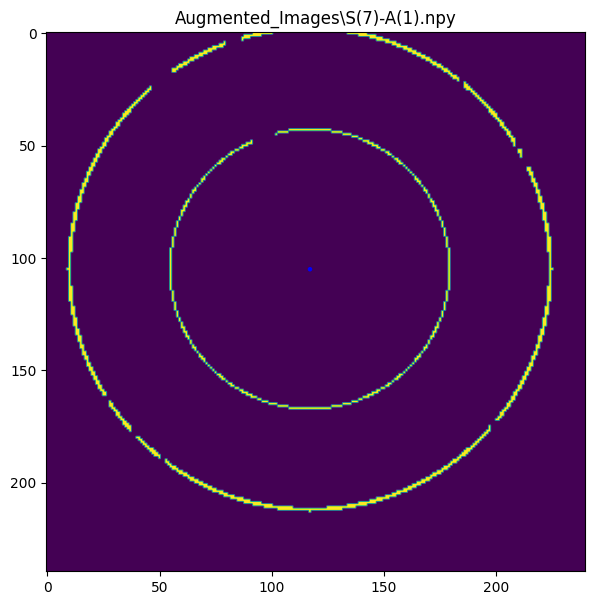

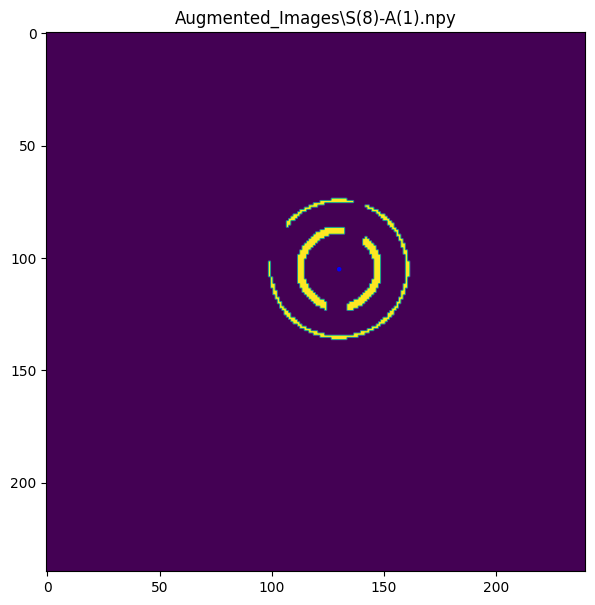

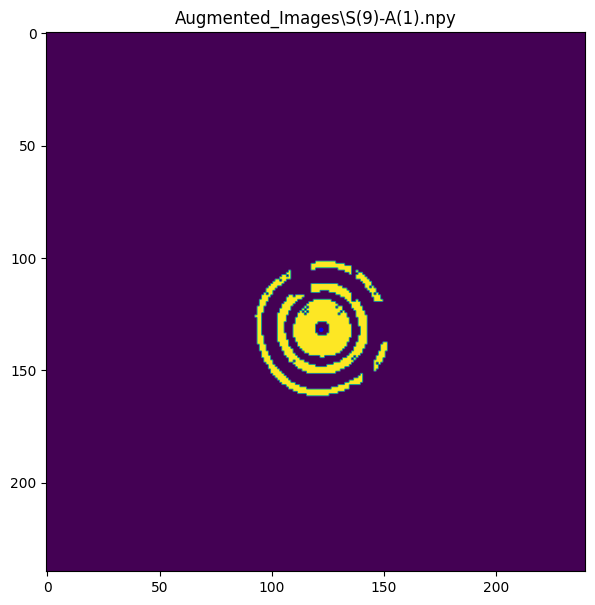

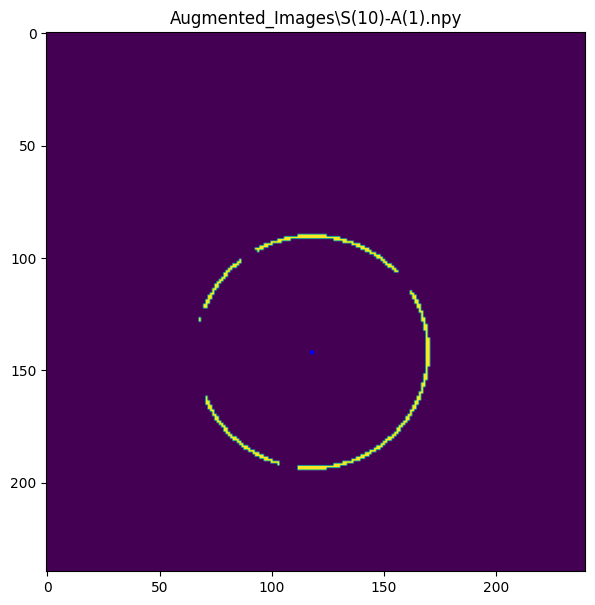

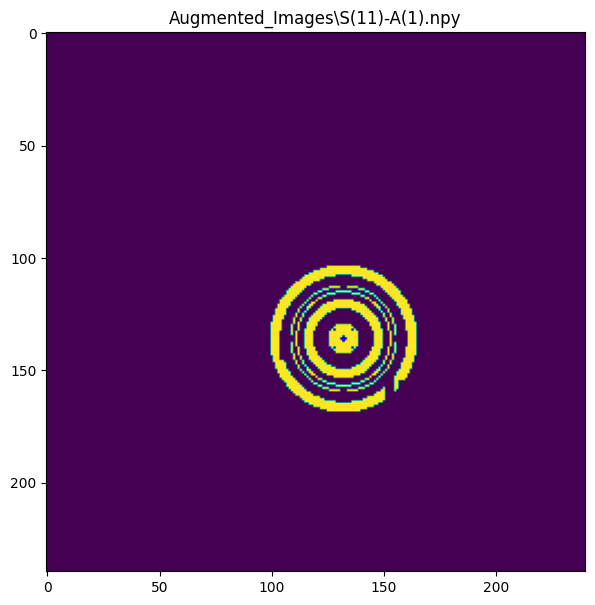

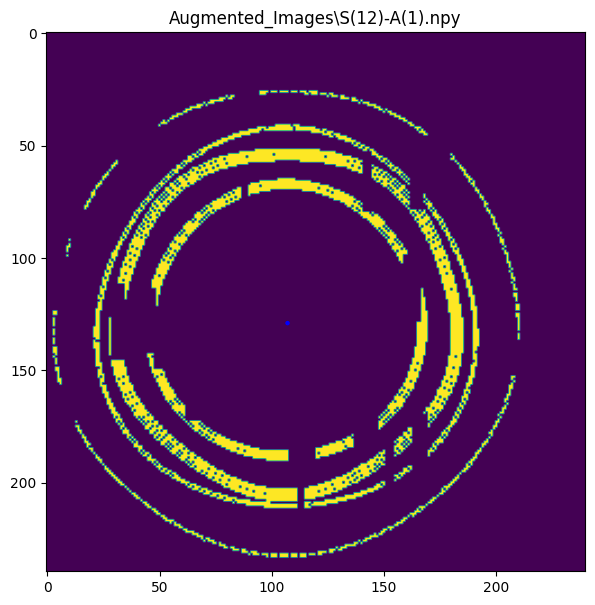

In [20]:
for i in np.arange(0, len(augment_frame), 2):
    fig, axs = plt.subplots(1, 1, figsize=[15, 7])
    img = np.load(augment_frame['file_path'][i])
    x, y = [augment_frame['center_x_ratio'][i], augment_frame['center_y_ratio'][i]]
    marker = mpatches.Circle((int(DIMENSION*x),int(DIMENSION*y)),
                    radius=1, facecolor='blue')
    axs.set_title(augment_frame['file_path'][i])
    axs.imshow(img)
    axs.add_patch(marker)
    plt.show()

In [21]:
lst = [1, 2, 3]

lst += [0 for x in range(20)]

(array([116, 117], dtype=int64), array([129, 129], dtype=int64))
(116, 129)
(117, 129)
(240, 240)
129.0 116.5


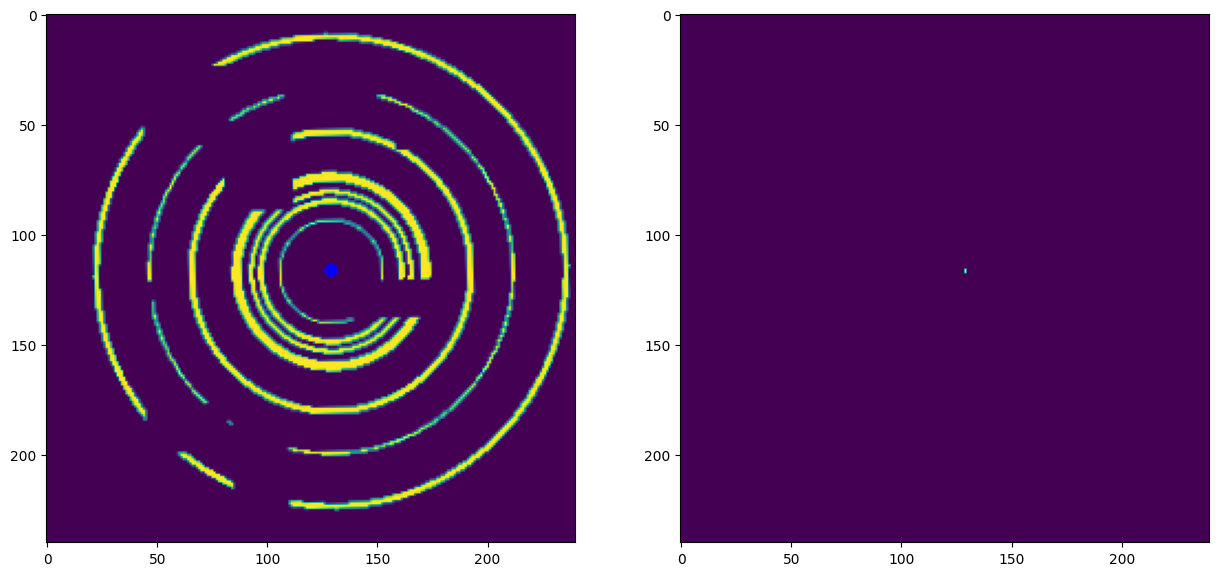

In [12]:
test = np.load('Seed_Images/S(1).npy')
helper = np.zeros((240, 240))
helper[120, 120] = 1

TRANSFORMATIONS = [T.Random_Patch(max_num_patch=25), T.Random_Shift(), T.Random_Rotate()]

for transform in TRANSFORMATIONS:
    test, helper = transform(test, helper)

indices = np.where(helper==1)
print(indices)
x, y, n = 0, 0, 0
for coord in zip(*indices):
    print(coord)
    x += coord[1]
    y += coord[0]
    n += 1

x, y = x/n, y/n

print(helper.shape)
print(x, y)


fig, axs = plt.subplots(1, 2, figsize=[15, 7])

marker = mpatches.Circle((int(x),int(y)),
                 radius=3, facecolor='blue')
axs[0].imshow(test)
axs[0].add_patch(marker)
axs[1].imshow(helper)